In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-13 18:09:49.001570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 18:09:49.627134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Additive Model: two-latent function model

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

2022-08-13 13:09:02.327712: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-13 13:09:10.128383: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x825f5c0


Epoch 50 - Loss:  5021.3365


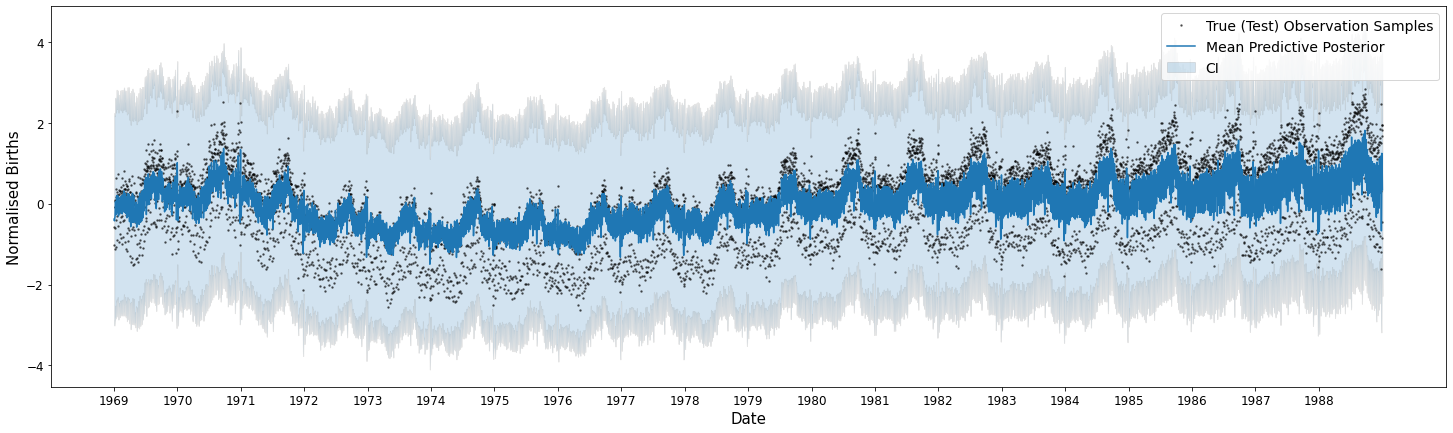

Fitted values MSE:  0.311117423453468
ELBO:  -5018.81937882506
percentage out of CI:  0.0


In [3]:
# build model & compute fitted values

kernel = gpflow.kernels.RBF() + gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 50

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        print('percentage out of CI: ', percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Change starting conditions

Epoch 50 - Loss:  4456.7228


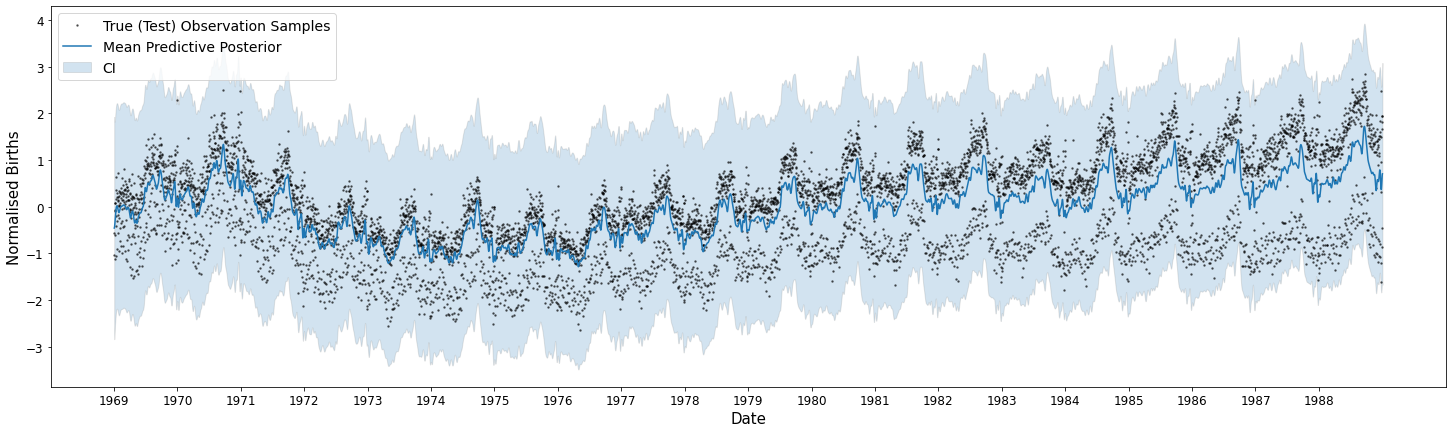

Fitted values MSE:  0.5358130219147353
ELBO:  -4449.065686255713
percentage out of CI:  0.0


In [5]:
kernel = gpflow.kernels.RBF(lengthscales=5) + gpflow.kernels.RBF(lengthscales=5)
likelihood = gpflow.likelihoods.Gaussian()

M = 3000  
Z = np.linspace(x.numpy().min(), x.numpy().max(), M)[:, None]

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)

data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)
set_trainable(model.likelihood.variance, False)

# adding priors
model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 50
log_freq = 50

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        mean, var = model.predict_y(x)
        plot_distribution(x, y, mean, var, pos, labels)
        print('Fitted values MSE: ', mean_squared_error(y, mean))
        print('ELBO: ', model.elbo((x,y)).numpy())
        print('percentage out of CI: ', percentage_outof_CI(y, mean, var))

print_summary(model, fmt='notebook')

Again we see these models are sensitive to starting values.

Need to look at train test for fair comparison of which is better.

-------------------------------------------------------------

# Train / Test split: model selection

Assess which kernel helps represent the data best.

    MSE, MAE, Likelihood

Since we have found that the starting point of kernel parameters affects the fit significantly, we will first select the kernel and then run an analysis to find optimal starting conditions for hyperparameters.

In [3]:
def optimise_predict_model(model, M=3000):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = 50
    log_freq = 50

    for epoch in range(1, epochs + 1):
        optimisation_step()

        # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
        if epoch % log_freq == 0 and epoch > 0:
            print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_f(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(model, fmt='notebook')

The models consist of a single latent function, untrainable noise variance (justify), hyperparameters with priors.

Epoch 50 - Loss:  4467.6863
Train


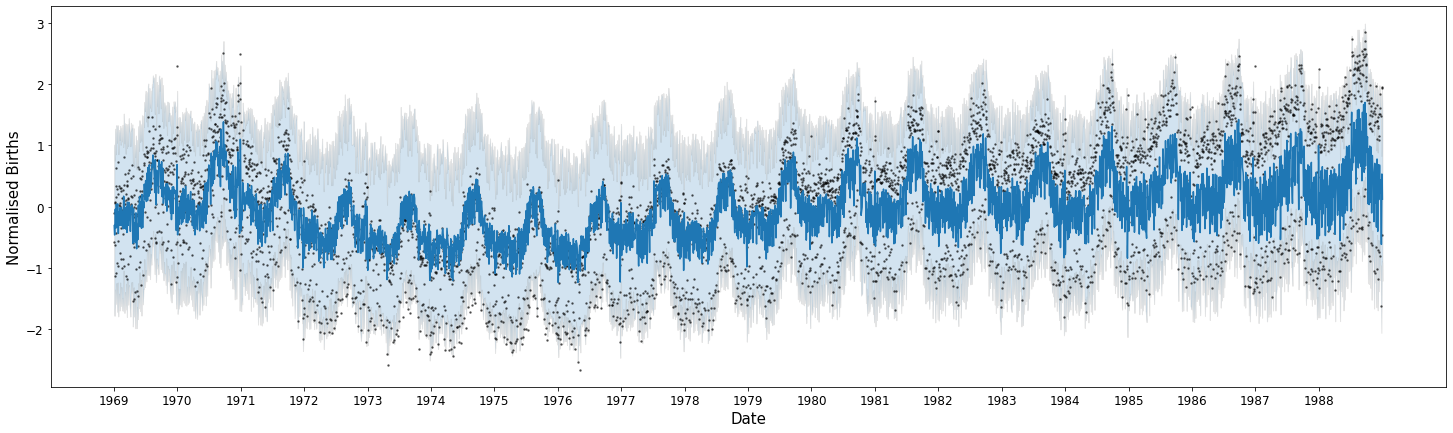

Test


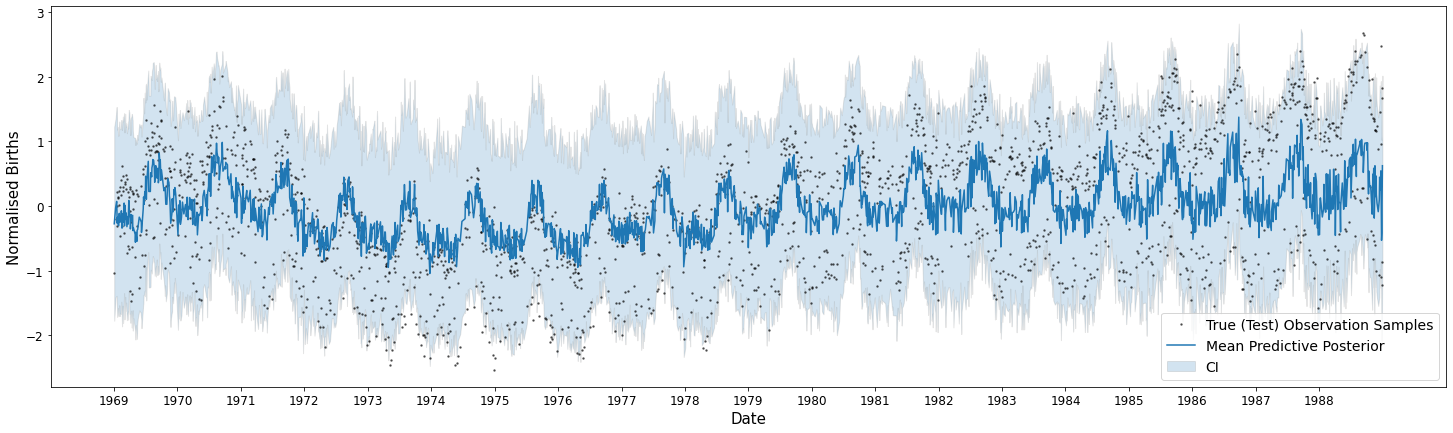

train ELBO, MSE, MAE:  -4465.5379433494 0.37714500975739196 0.5164041693329288
test ELBO, MSE, MAE:  -5113.638132055696 0.6772950132310097 0.69664051189165
percentage out of CI (train, test):  1.4081752395853706 4.516423357664234


--------------------------------------------------------
Epoch 50 - Loss:  4992.0072
Train


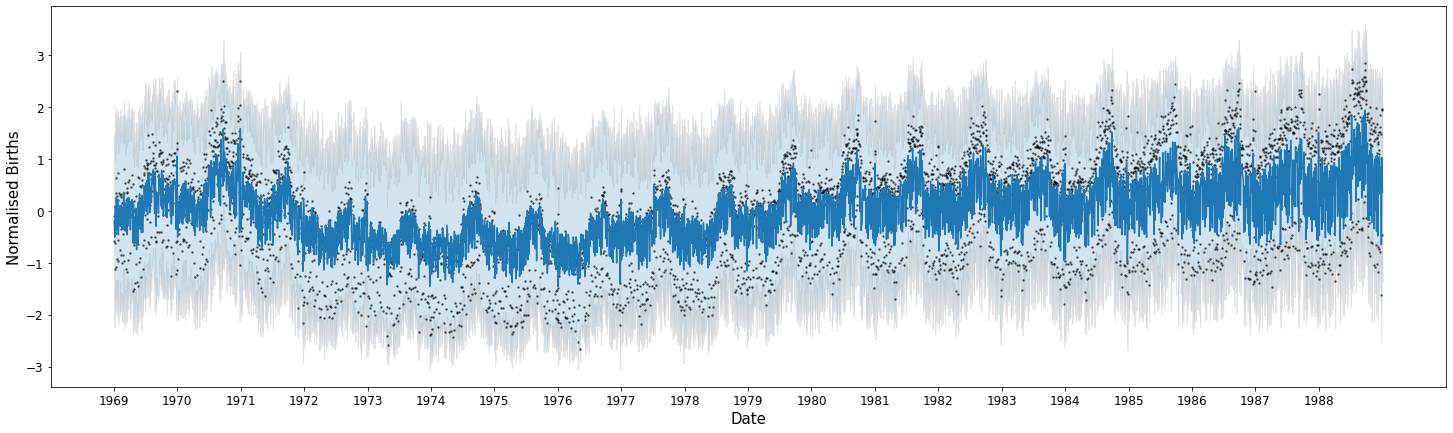

Test


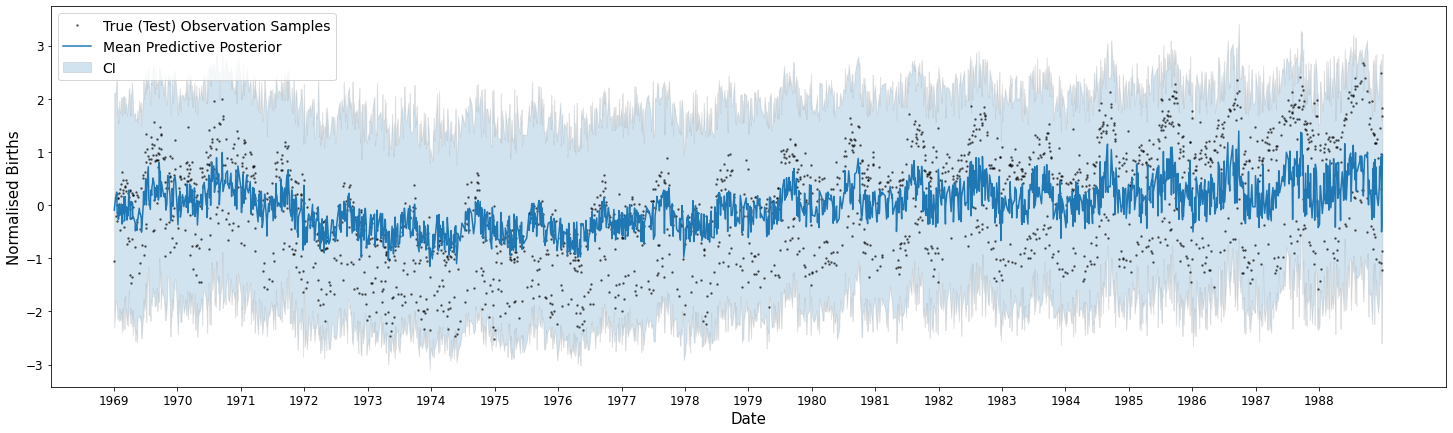

train ELBO, MSE, MAE:  -4989.498426045402 0.2764665729409542 0.43610507917820523
test ELBO, MSE, MAE:  -6047.291339745801 0.6548812758555072 0.6783253171133441
percentage out of CI (train, test):  0.0 0.13686131386861314


--------------------------------------------------------
Epoch 50 - Loss:  4885.5783
Train


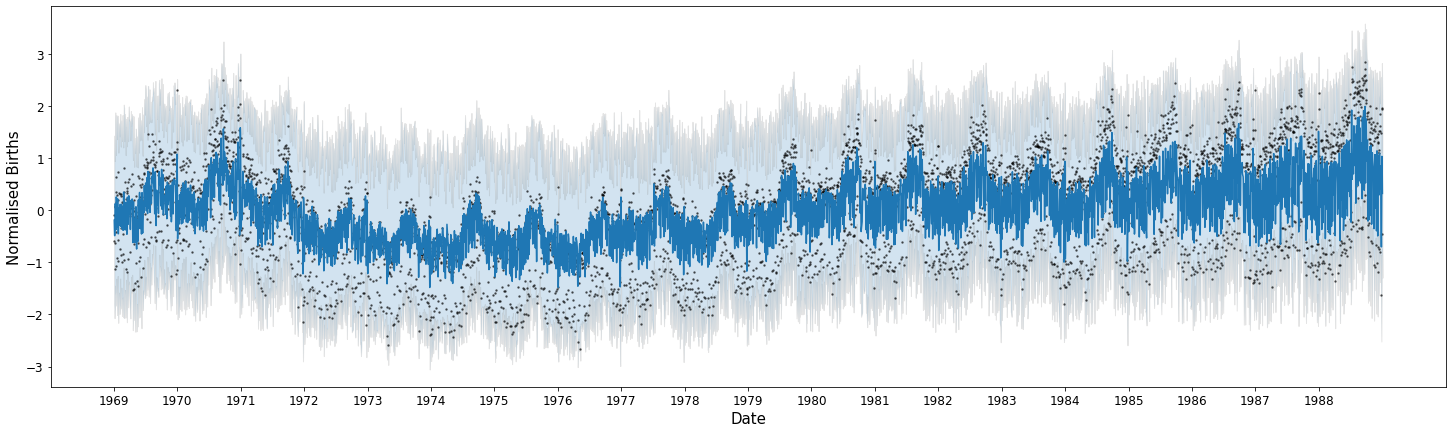

Test


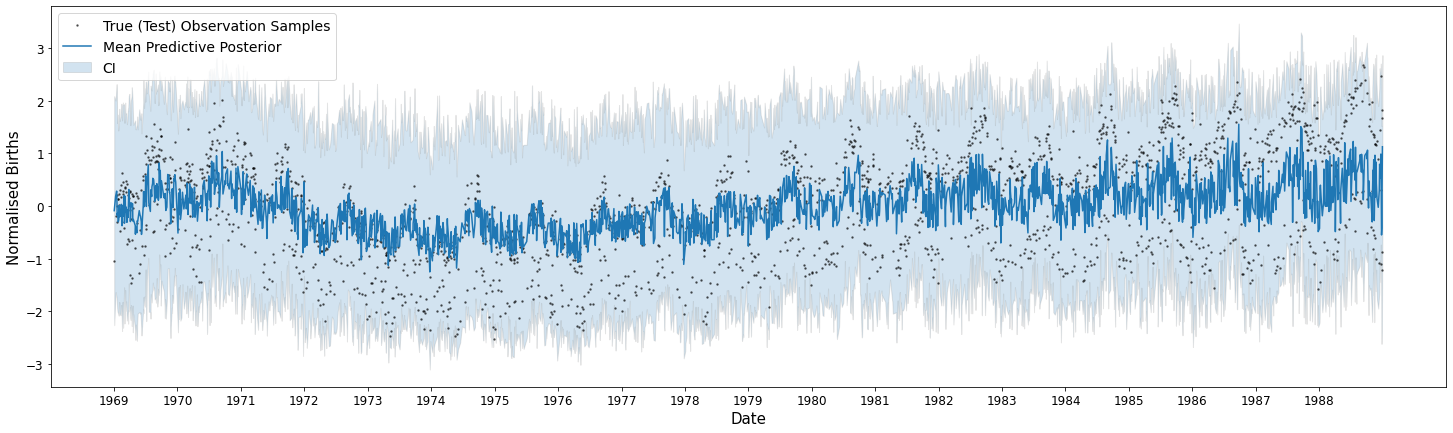

train ELBO, MSE, MAE:  -4883.057652700446 0.2673234571327891 0.42764499951288193
test ELBO, MSE, MAE:  -5935.097211849238 0.6410025230155374 0.6689724412897189
percentage out of CI (train, test):  0.0 0.13686131386861314


--------------------------------------------------------


In [7]:
# Kernel MODEL SELECTION
kernel_list = [gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25), gpflow.kernels.Matern32(), gpflow.kernels.RBF()]

for i in range(len(kernel_list)):
    print(kernel_list[i])

    kernel = gpflow.kernels.RBF() + kernel_list[i]

    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
    model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    

    if i == 0:
        set_trainable(model.kernel.kernels[1].period, False)
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(3), to_default_float(2))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
    else:
        model.kernel.kernels[1].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

    
    optimise_predict_model(model)
    print('--------------------------------------------------------')

The kernel with best performance: periodic with set period bc CI is better.

Now, we would carry out the sensitivity analysis done before but on the train test set.

Starting Values (l0, l1):  1 1


2022-08-13 18:10:19.439826: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-13 18:10:27.544996: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8a9e350


Epoch 50 - Loss:  4467.3310
Train


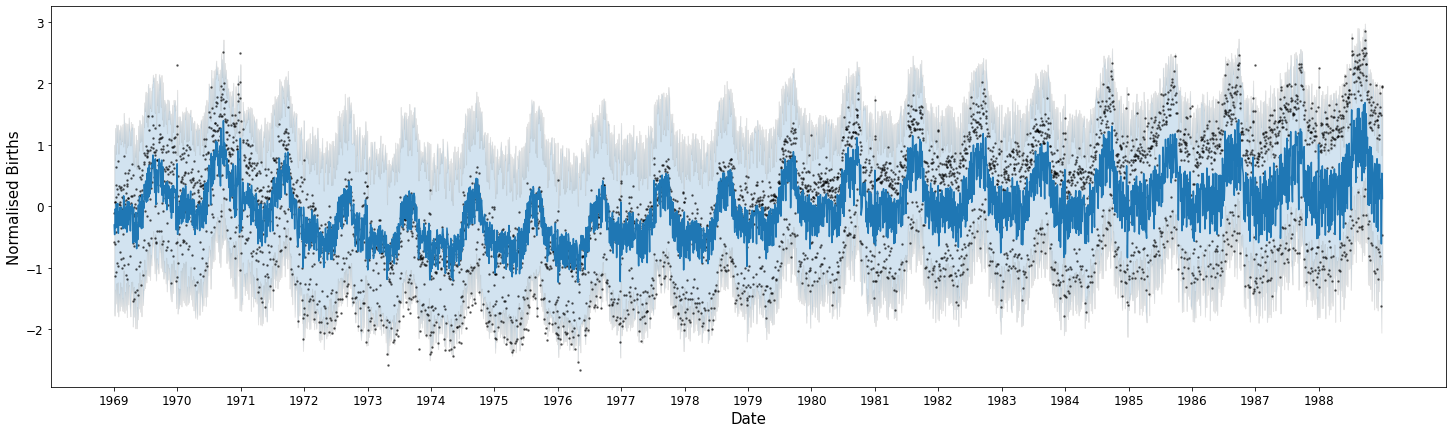

Test


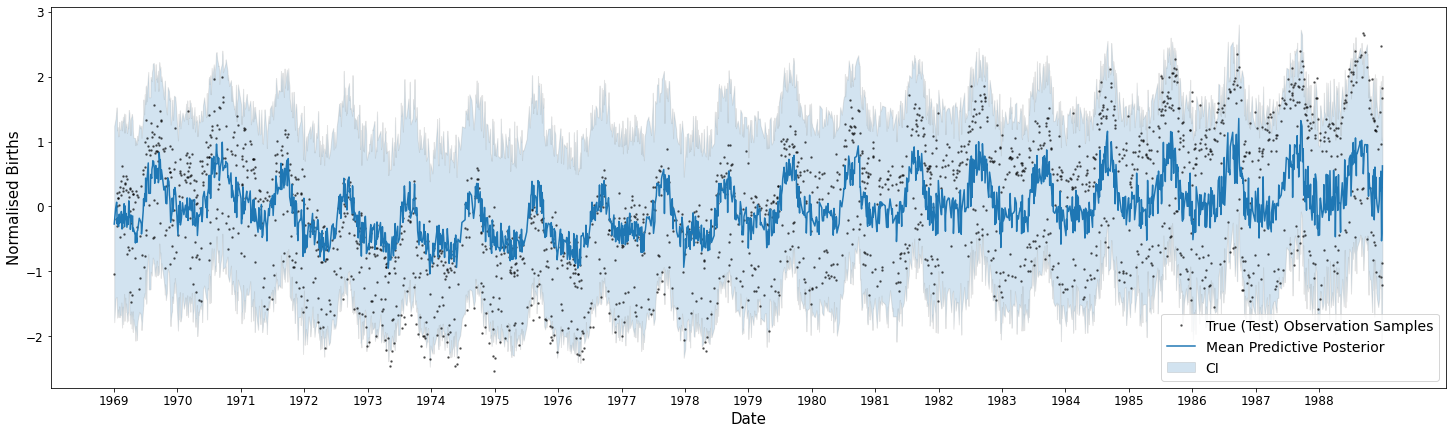

train ELBO, MSE, MAE:  -4464.840752797159 0.37698261269498423 0.5164357260733177
test ELBO, MSE, MAE:  -5113.526305353916 0.6775270075527534 0.696868705002472
percentage out of CI (train, test):  1.3299432818306278 4.288321167883212


--------------------------------------------------------
Starting Values (l0, l1):  1 5
Epoch 50 - Loss:  4482.0233
Train


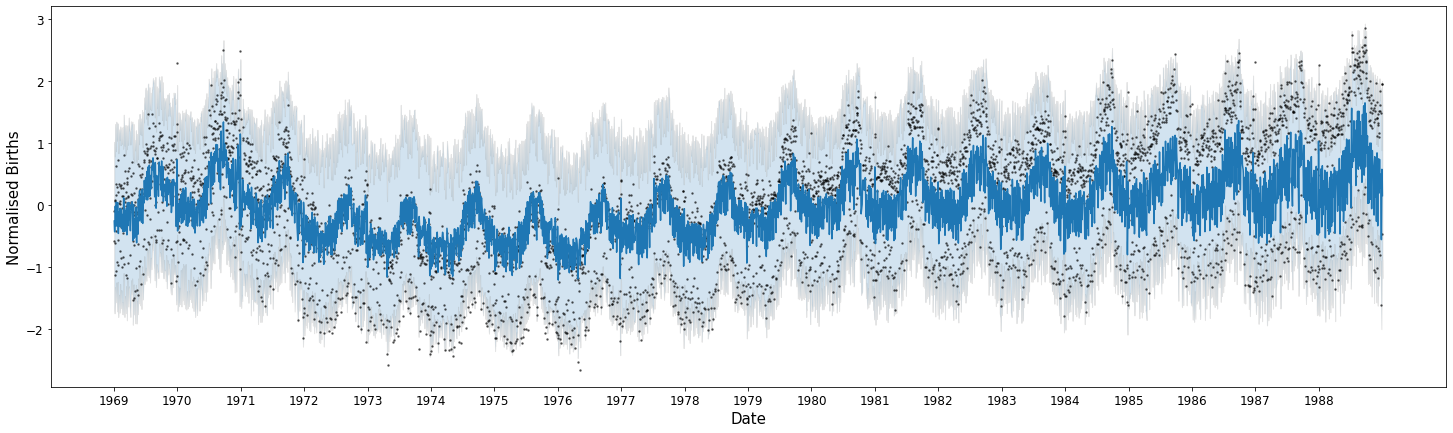

Test


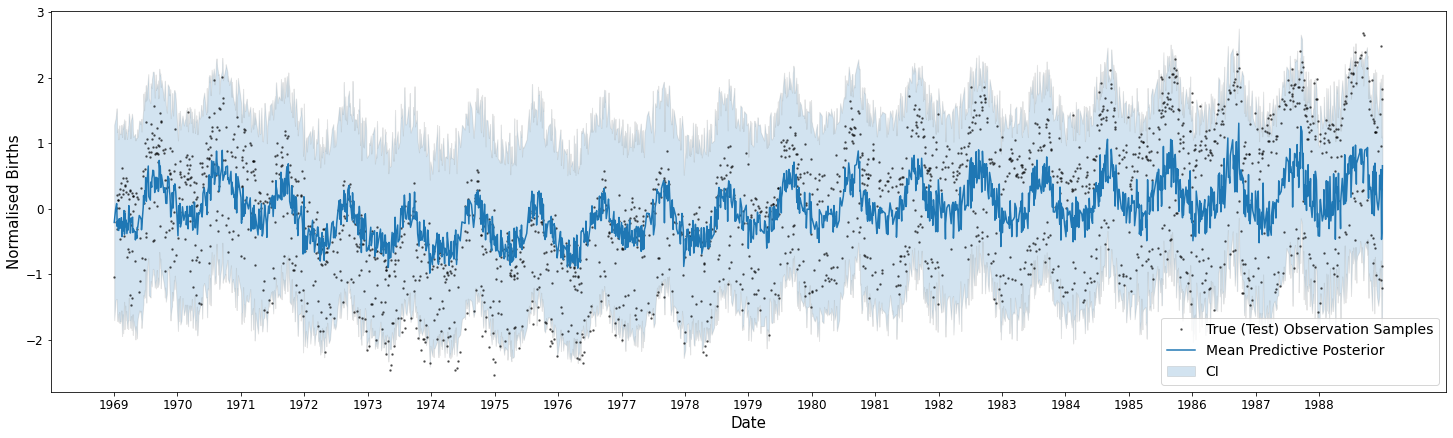

train ELBO, MSE, MAE:  -4476.98277590793 0.3810694588100862 0.5184227919269074
test ELBO, MSE, MAE:  -5139.273321209744 0.6908408533391516 0.7022281706099746
percentage out of CI (train, test):  1.4668492079014277 5.063868613138686


--------------------------------------------------------
Starting Values (l0, l1):  5 1
Epoch 50 - Loss:  4204.0296
Train


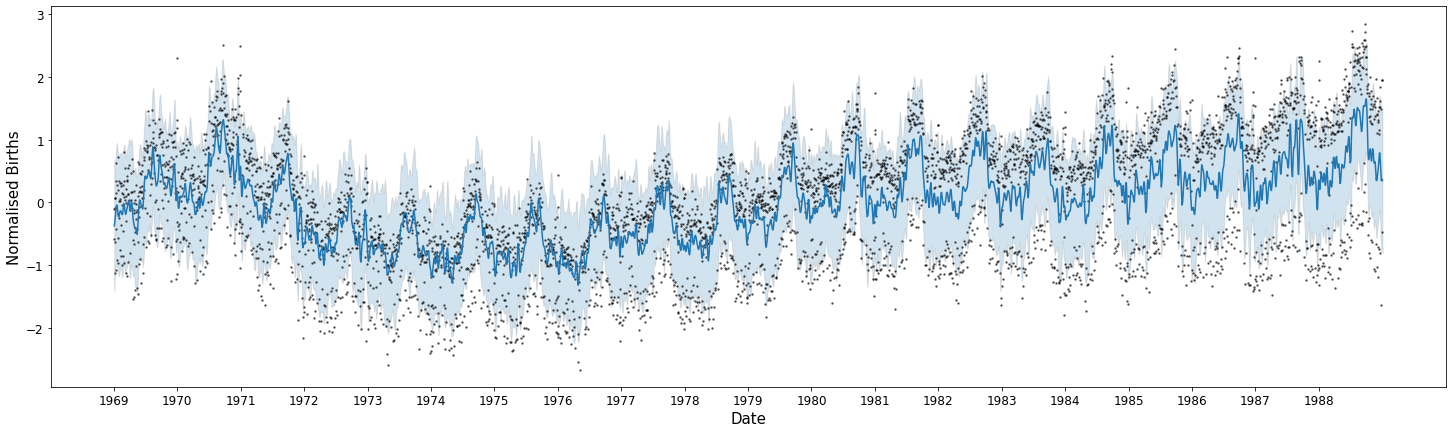

Test


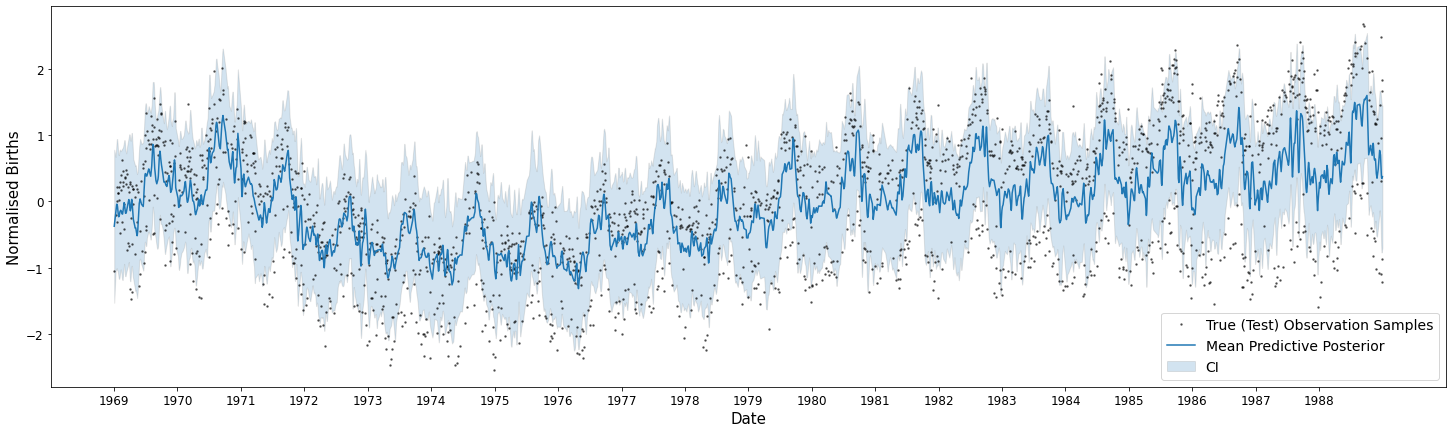

train ELBO, MSE, MAE:  -4198.963230953443 0.5188370899765151 0.6033966144895091
test ELBO, MSE, MAE:  -4500.2908157999145 0.688212568707896 0.6981503690843162
percentage out of CI (train, test):  24.330138861725015 28.87773722627737


--------------------------------------------------------
Starting Values (l0, l1):  5 5
Epoch 50 - Loss:  4211.3173
Train


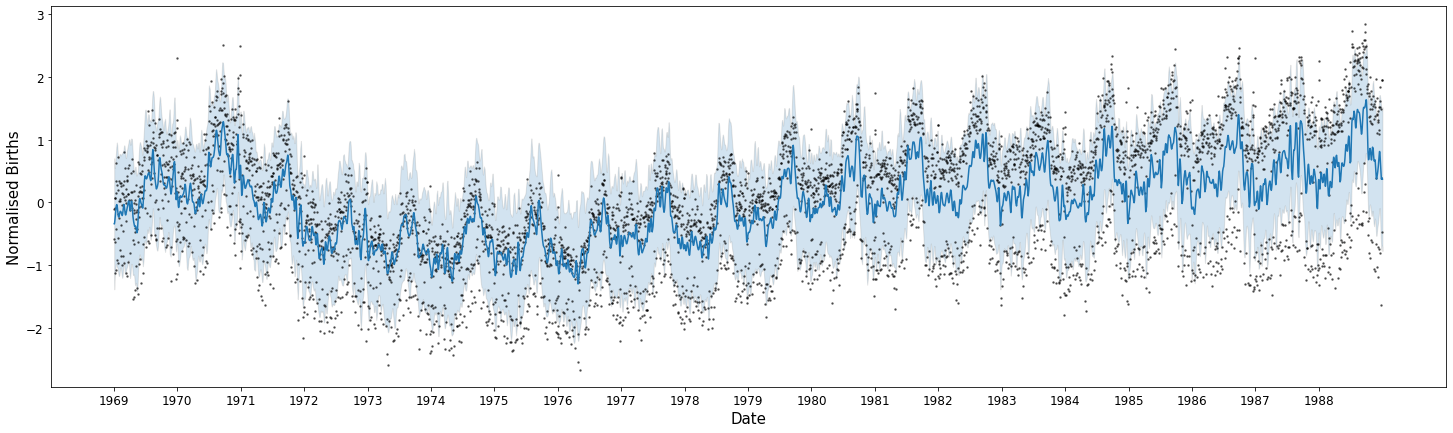

Test


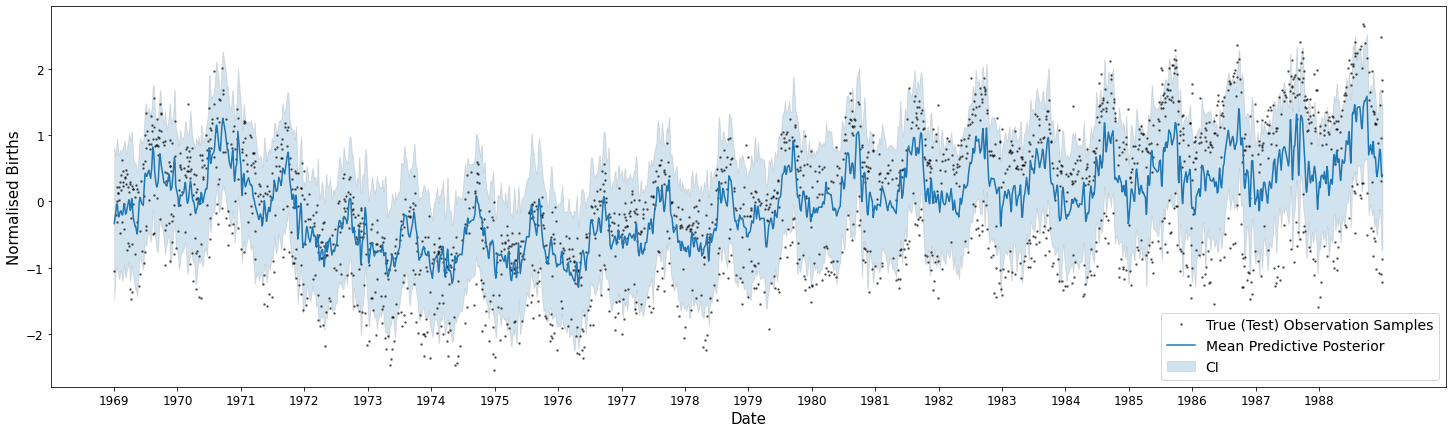

train ELBO, MSE, MAE:  -4203.791750932253 0.5196341115683859 0.6042926894106566
test ELBO, MSE, MAE:  -4508.122057018483 0.6910164089608613 0.7002195945458327
percentage out of CI (train, test):  24.3496968511637 28.87773722627737


--------------------------------------------------------
Starting Values (l0, l1):  10 1
Epoch 50 - Loss:  4042.1091
Train


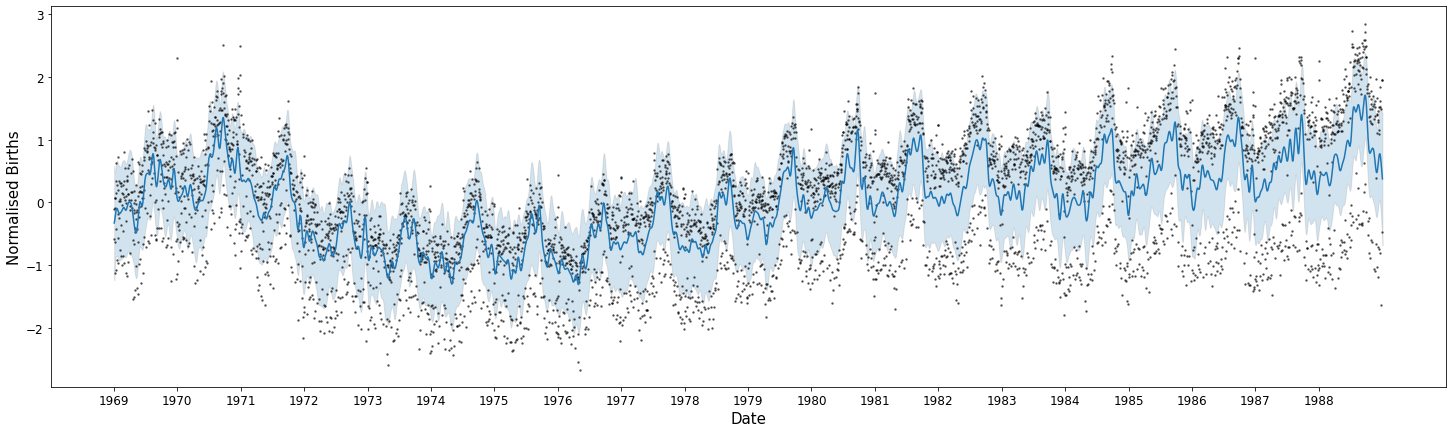

Test


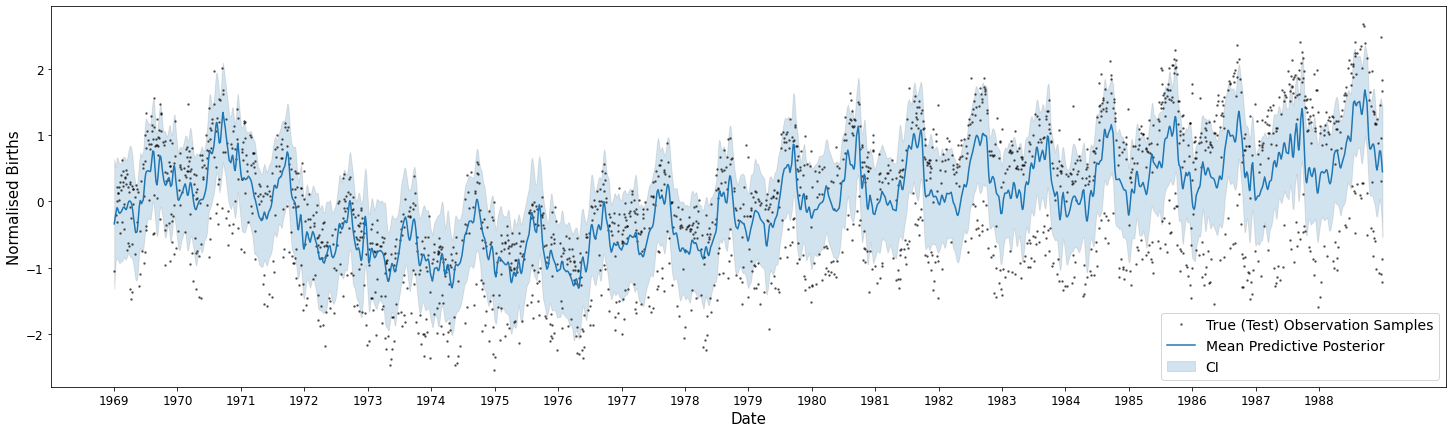

train ELBO, MSE, MAE:  -4035.340530149839 0.5284159042769229 0.6112600994591063
test ELBO, MSE, MAE:  -4209.766066875562 0.6322224147573213 0.669998687434523
percentage out of CI (train, test):  35.49775083121455 38.18430656934307


--------------------------------------------------------
Starting Values (l0, l1):  10 5
Epoch 50 - Loss:  4047.1881
Train


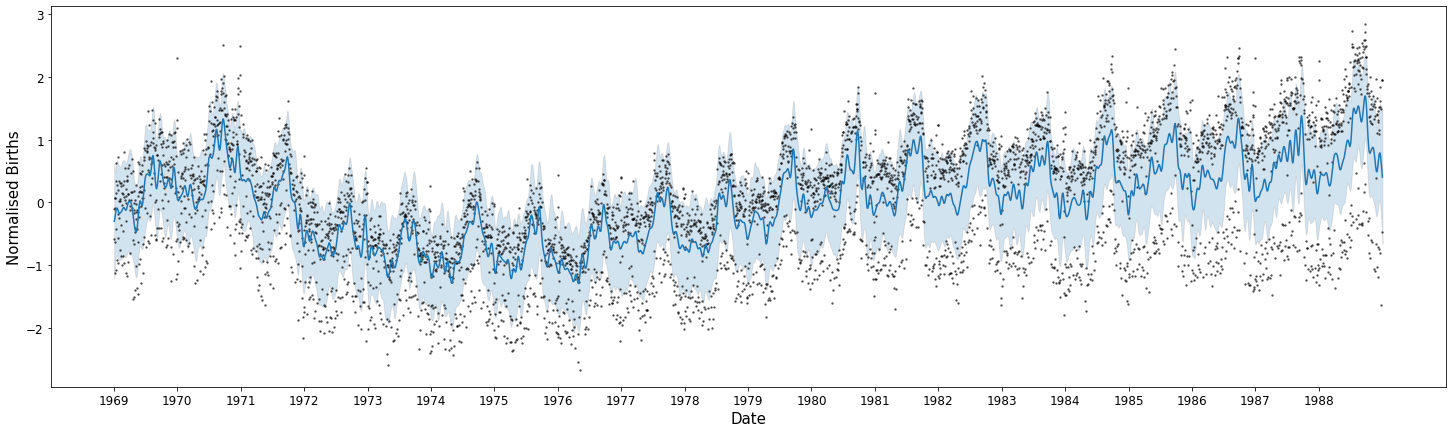

Test


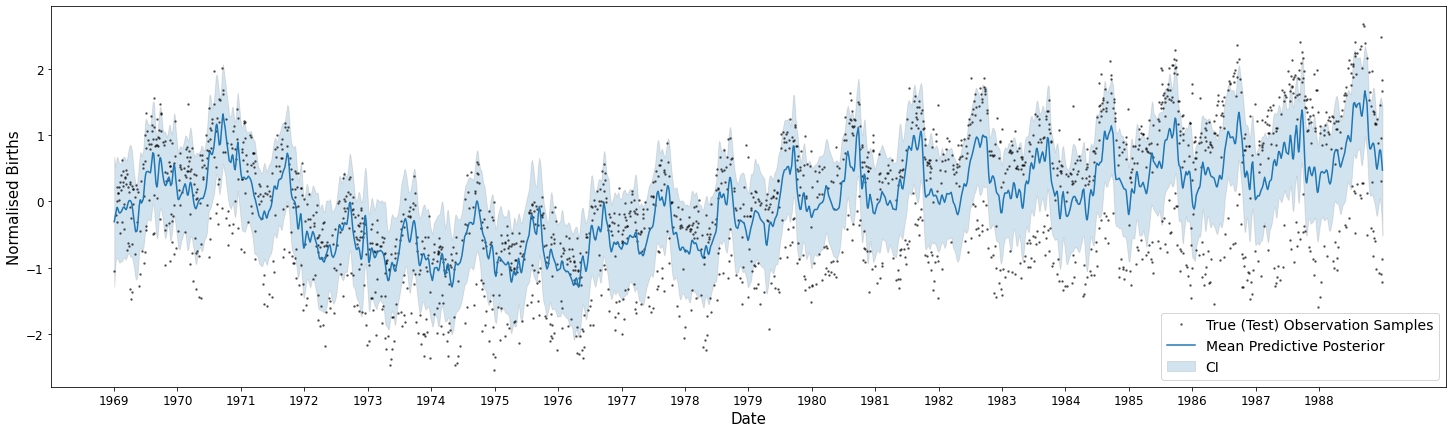

train ELBO, MSE, MAE:  -4038.1008398493177 0.5288012518238682 0.6118610284564062
test ELBO, MSE, MAE:  -4213.779555476085 0.6334455282562925 0.6710474063432686
percentage out of CI (train, test):  35.36084490514375 38.41240875912409


--------------------------------------------------------
Starting Values (l0, l1):  19 1
Epoch 50 - Loss:  3917.0868
Train


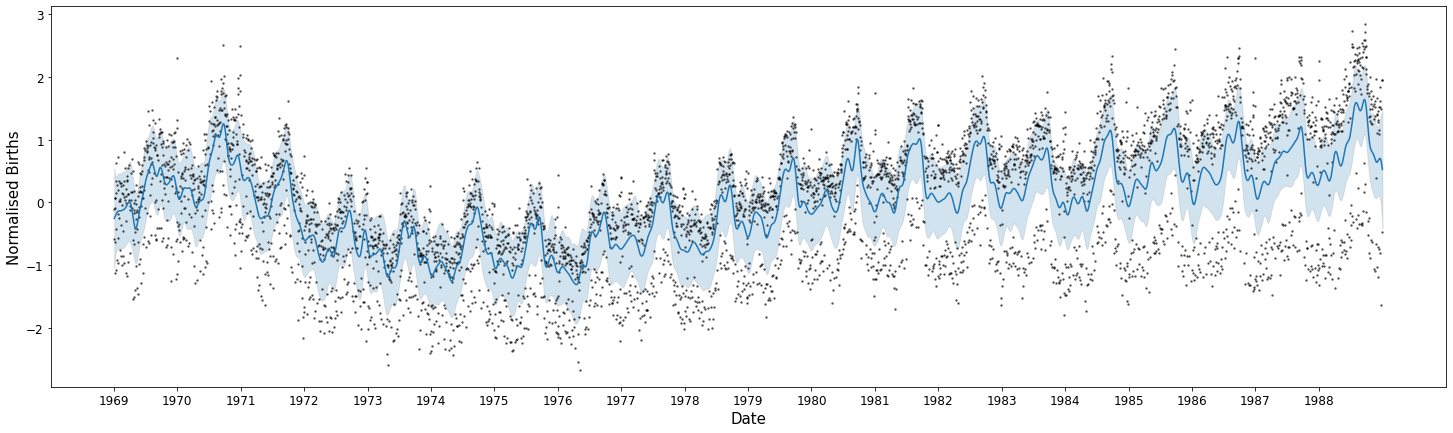

Test


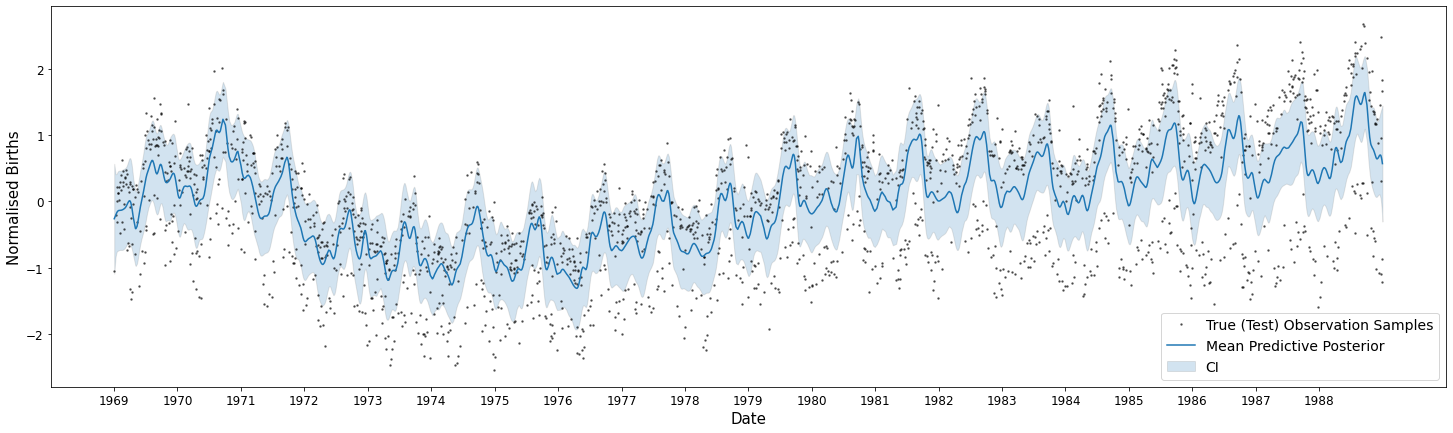

train ELBO, MSE, MAE:  -3908.567723259517 0.5375606561157258 0.6183283696166547
test ELBO, MSE, MAE:  -4014.0703561270743 0.6029507183269605 0.6552258858132953
percentage out of CI (train, test):  47.34989243105809 48.67700729927007


--------------------------------------------------------
Starting Values (l0, l1):  19 5
Epoch 50 - Loss:  3920.7040
Train


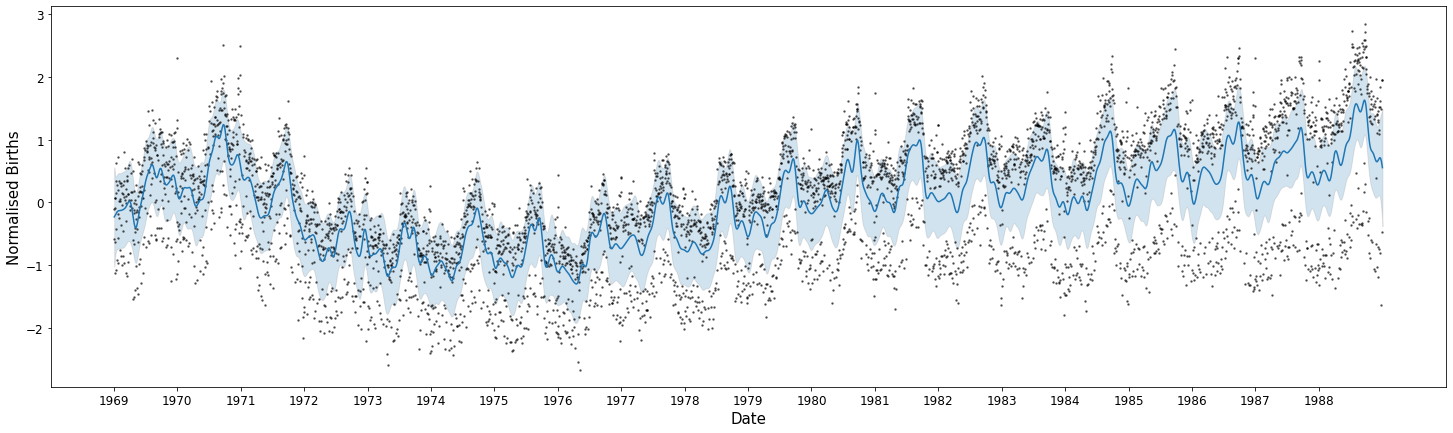

Test


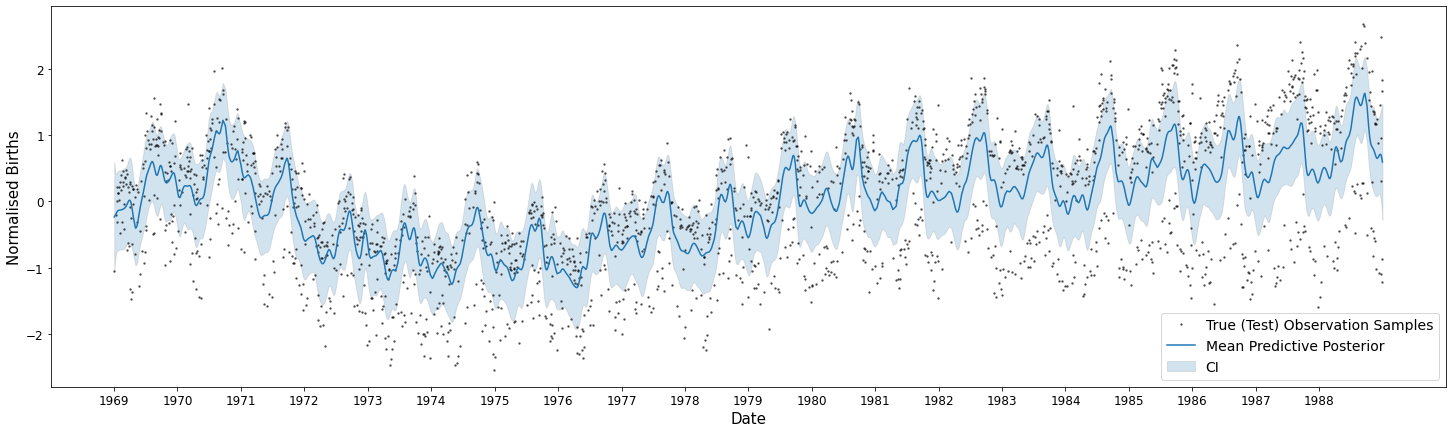

train ELBO, MSE, MAE:  -3910.032773722309 0.537784977565764 0.6187351614293619
test ELBO, MSE, MAE:  -4016.144317990973 0.6035819176247796 0.6558070812169703
percentage out of CI (train, test):  47.29121846274203 48.9051094890511


--------------------------------------------------------


In [5]:
starting_values_l0 = [1, 5, 10, 19]
starting_values_l1 = [1, 5]
M = 3000

for l0 in starting_values_l0:
    for l1 in starting_values_l1:
        print('Starting Values (l0, l1): ', l0, l1)
        kernel = gpflow.kernels.RBF(lengthscales=l0) + gpflow.kernels.Periodic(gpflow.kernels.RBF(lengthscales=l1), period=365.25)
        Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
        model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
        set_trainable(model.likelihood.variance, False)
        
        model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(2), to_default_float(3))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

        optimise_predict_model(model)
        print('--------------------------------------------------------')

Starting conditions 1,1 seem to be overfitting. 5,1 although has a worse train mse, it is closer to test mse, less overfitting.

Try 1,1 but less epochs.

Starting Values (l, v):  10 1
Epoch 20 - Loss:  4016.9012
Epoch 40 - Loss:  3971.3598
Epoch 60 - Loss:  3948.0477
Epoch 80 - Loss:  3930.0529
Epoch 100 - Loss:  3915.0845
Train


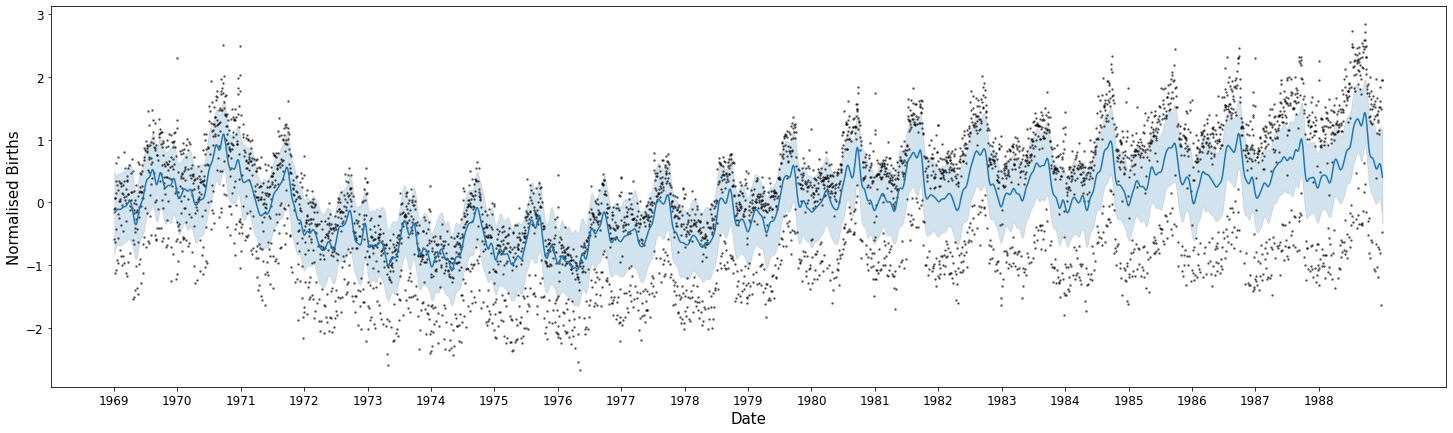

Epoch 120 - Loss:  3902.3034
Epoch 140 - Loss:  3891.2182
Epoch 160 - Loss:  3881.4858
Epoch 180 - Loss:  3872.8538
Epoch 200 - Loss:  3865.1326
Test


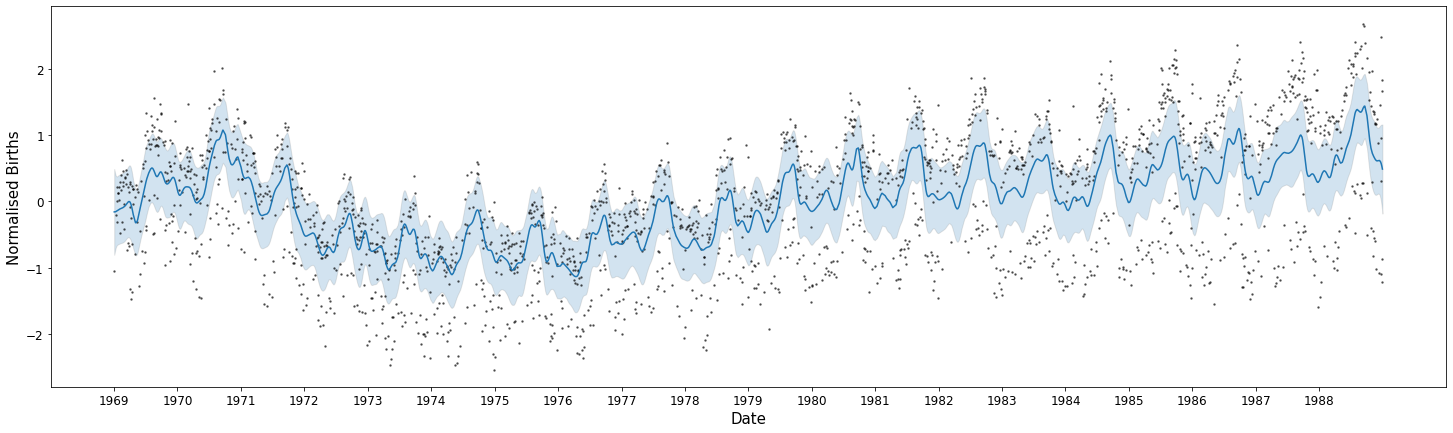

train ELBO, MSE, MAE:  -3860.1474899854566 0.5544692064041653 0.6270815803946922
test ELBO, MSE, MAE:  -3946.015151910794 0.6057635060413048 0.655983157256647
percentage out of CI (train, test):  51.67220809700763 56.75182481751825


In [14]:
print('Starting Values (l, v): ', 10, 1)
kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
M = 2000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.1)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 200
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')

_________________

Plot for write up

Epoch 20 - Loss:  4682.1905
Epoch 40 - Loss:  4557.5528
Epoch 60 - Loss:  4485.6346
Epoch 80 - Loss:  4436.1857
Epoch 100 - Loss:  4399.2020
Train


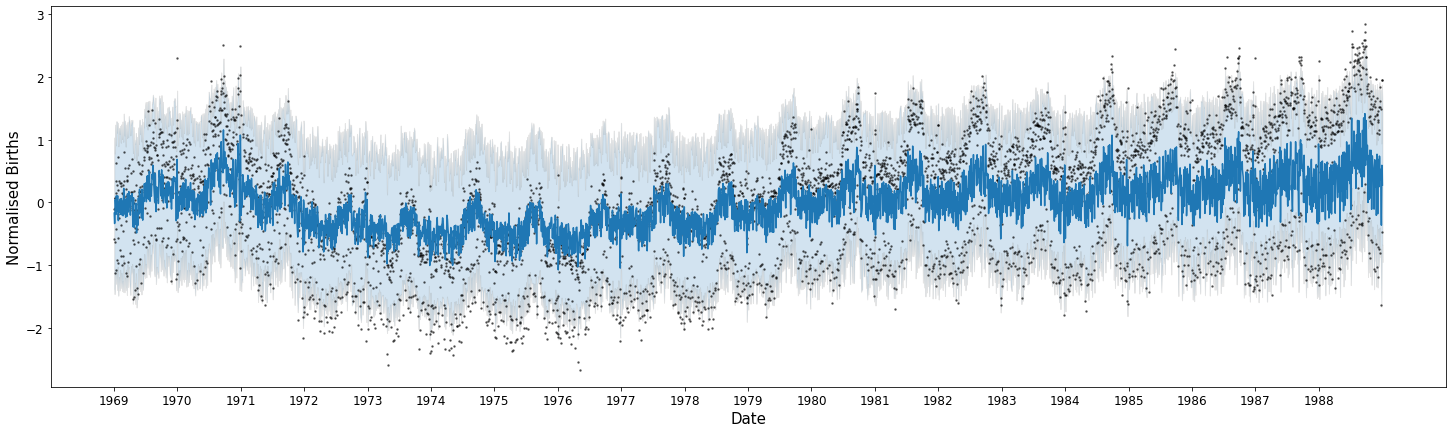

Test


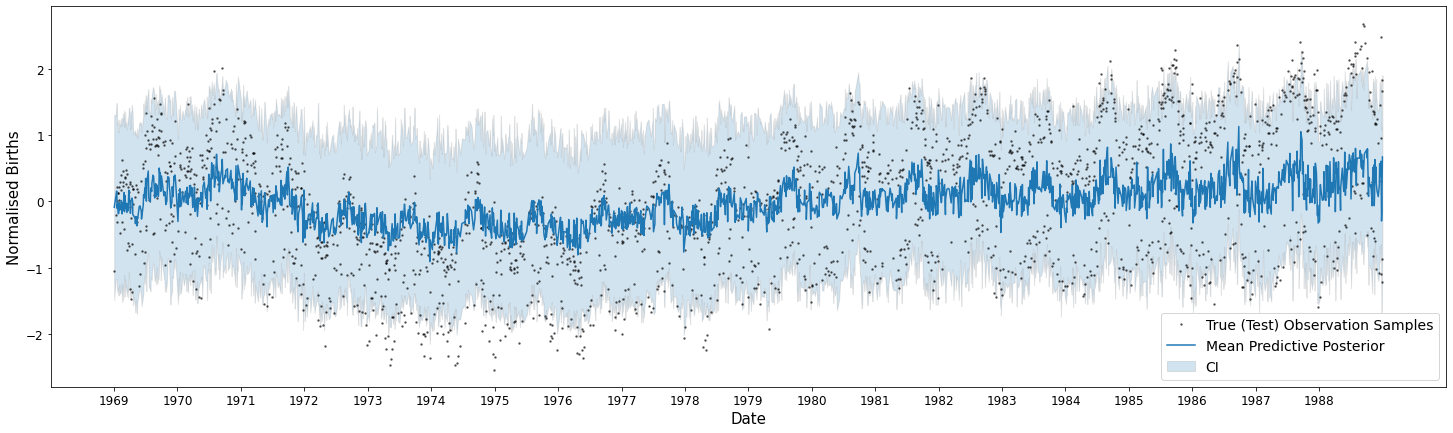

train ELBO, MSE, MAE:  -4397.202587573558 0.4402369687412963 0.5542282682161116
test ELBO, MSE, MAE:  -4961.5362556201835 0.724804026873664 0.7183912116470241
percentage out of CI (train, test):  6.630158419714453 11.861313868613138


In [7]:
kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
M = 3000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')

Epoch 20 - Loss:  4169.7515
Epoch 40 - Loss:  4144.0343
Epoch 60 - Loss:  4121.6823
Epoch 80 - Loss:  4100.7776
Epoch 100 - Loss:  4081.6571
Train


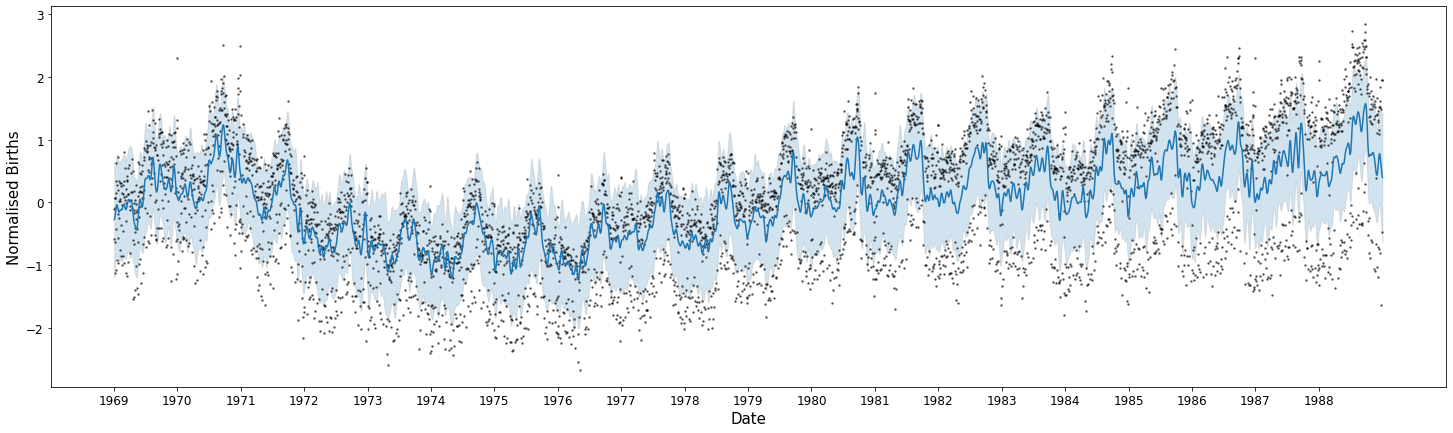

Test


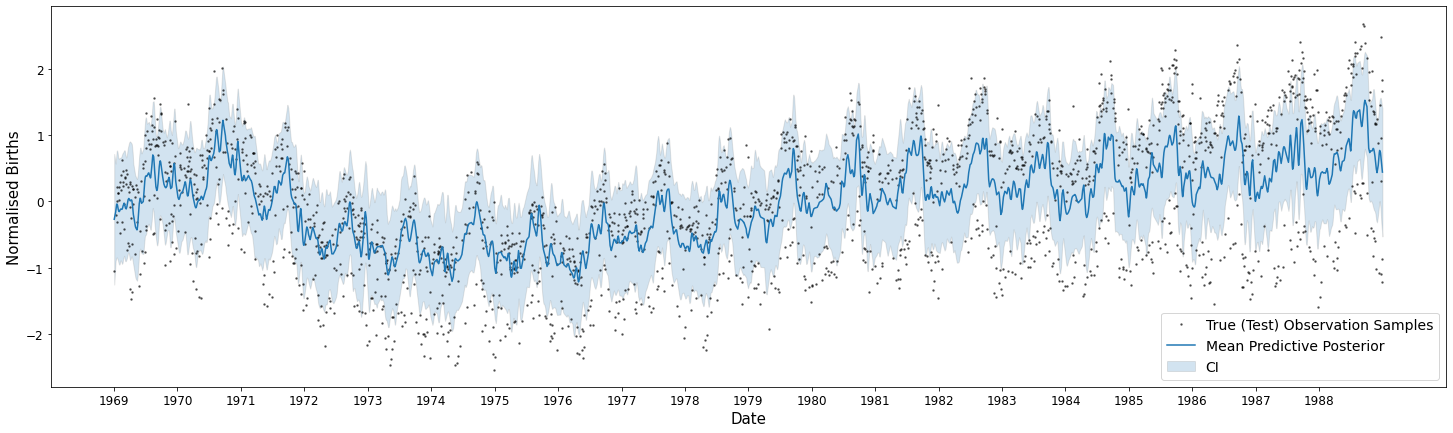

train ELBO, MSE, MAE:  -4077.733263590724 0.5332479169969222 0.613298965325451
test ELBO, MSE, MAE:  -4282.045049442615 0.6534500406143157 0.6809864795188081
percentage out of CI (train, test):  33.50283590846861 37.86496350364963


In [8]:
kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
M = 3000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')